In [2]:
from KKT_NN_GPT_copy import KKT_NN
from pickle import load
import numpy as np
import torch
import pandas as pd
from pandas.plotting import parallel_coordinates
import seaborn as sns

In [3]:
model = KKT_NN()
model.solnet.load_state_dict(torch.load("solnet.pt"))
model.lambdanet.load_state_dict(torch.load("lambdanet.pt"))

<All keys matched successfully>

In [4]:
samples = load(open("mpc.pkl", "rb"))
a = [None]*len(samples); b= [None]*len(samples);r = [None]*len(samples);x_0 = [None]*len(samples);x_ref = [None]*len(samples);y = [None]*len(samples)
for i in range(len(samples)):
    a[i],b[i],r[i], x_0[i], x_ref[i], y[i] = samples[i]
a=torch.tensor(a, dtype=torch.float32, device=torch.device("mps"))
b=torch.tensor(b, dtype=torch.float32, device=torch.device("mps"))
r=torch.tensor(r, dtype=torch.float32, device=torch.device("mps"))
x_0=torch.tensor(x_0, dtype=torch.float32, device=torch.device("mps"))
x_ref=torch.tensor(x_ref, dtype=torch.float32, device=torch.device("mps"))
y=torch.tensor(y, dtype=torch.float32, device=torch.device("mps"))

/var/folders/x0/fjnzwgpj3pndx212mlrpc1mh0000gn/T/ipykernel_4949/431729185.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1719361022906/work/torch/csrc/utils/tensor_new.cpp:277.)
  y=torch.tensor(y, dtype=torch.float32, device=torch.device("mps"))


In [5]:
sobol = torch.quasirandom.SobolEngine(5, scramble=True, seed=42)

In [30]:
batch = sobol.draw(10000).to(torch.device("mps"))

a = 0.3*batch[...,0]+0.7
b = 0.4*batch[...,1]+0.1
r = batch[..., 2]
x_0 = batch[..., 3]
x_ref = batch[..., 4]

In [31]:
stationarity, feasibility, complementary = model.kkt_loss(a,b,r,x_0,x_ref)

In [32]:
df = pd.DataFrame(torch.stack([a,b,r,x_0,x_ref], 1).cpu().detach(), columns=['a', 'b', 'r', 'x_0', 'x_ref'])

In [33]:
df = pd.DataFrame(torch.stack([a,b,r,x_0,x_ref, stationarity, feasibility, complementary], 1).cpu().detach(), columns=['a', 'b', 'r', 'x_0', 'x_ref', 'stat', 'feas', 'compl'])

In [34]:
df.corr()

,a,b,r,x_0,x_ref,stat,feas,compl
a,1.000000,0.000229,-0.000144,0.000300,-0.000976,0.161671,0.282632,0.093577
b,0.000229,1.000000,-0.000384,-0.000127,-0.000038,0.332918,0.247211,0.051357
r,-0.000144,-0.000384,1.000000,0.000356,-0.000300,0.340214,-0.003683,0.001345
x_0,0.000300,-0.000127,0.000356,1.000000,0.000173,0.417349,0.470160,0.911084
x_ref,-0.000976,-0.000038,-0.000300,0.000173,1.000000,-0.530057,0.010852,0.305303
stat,0.161671,0.332918,0.340214,0.417349,-0.530057,1.000000,0.485335,0.202645
feas,0.282632,0.247211,-0.003683,0.470160,0.010852,0.485335,1.000000,0.511624
compl,0.093577,0.051357,0.001345,0.911084,0.305303,0.202645,0.511624,1.000000


/var/folders/x0/fjnzwgpj3pndx212mlrpc1mh0000gn/T/ipykernel_4949/118570156.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  g = sns.PairGrid(df.drop(["feas", "compl"], 1), hue="stat")


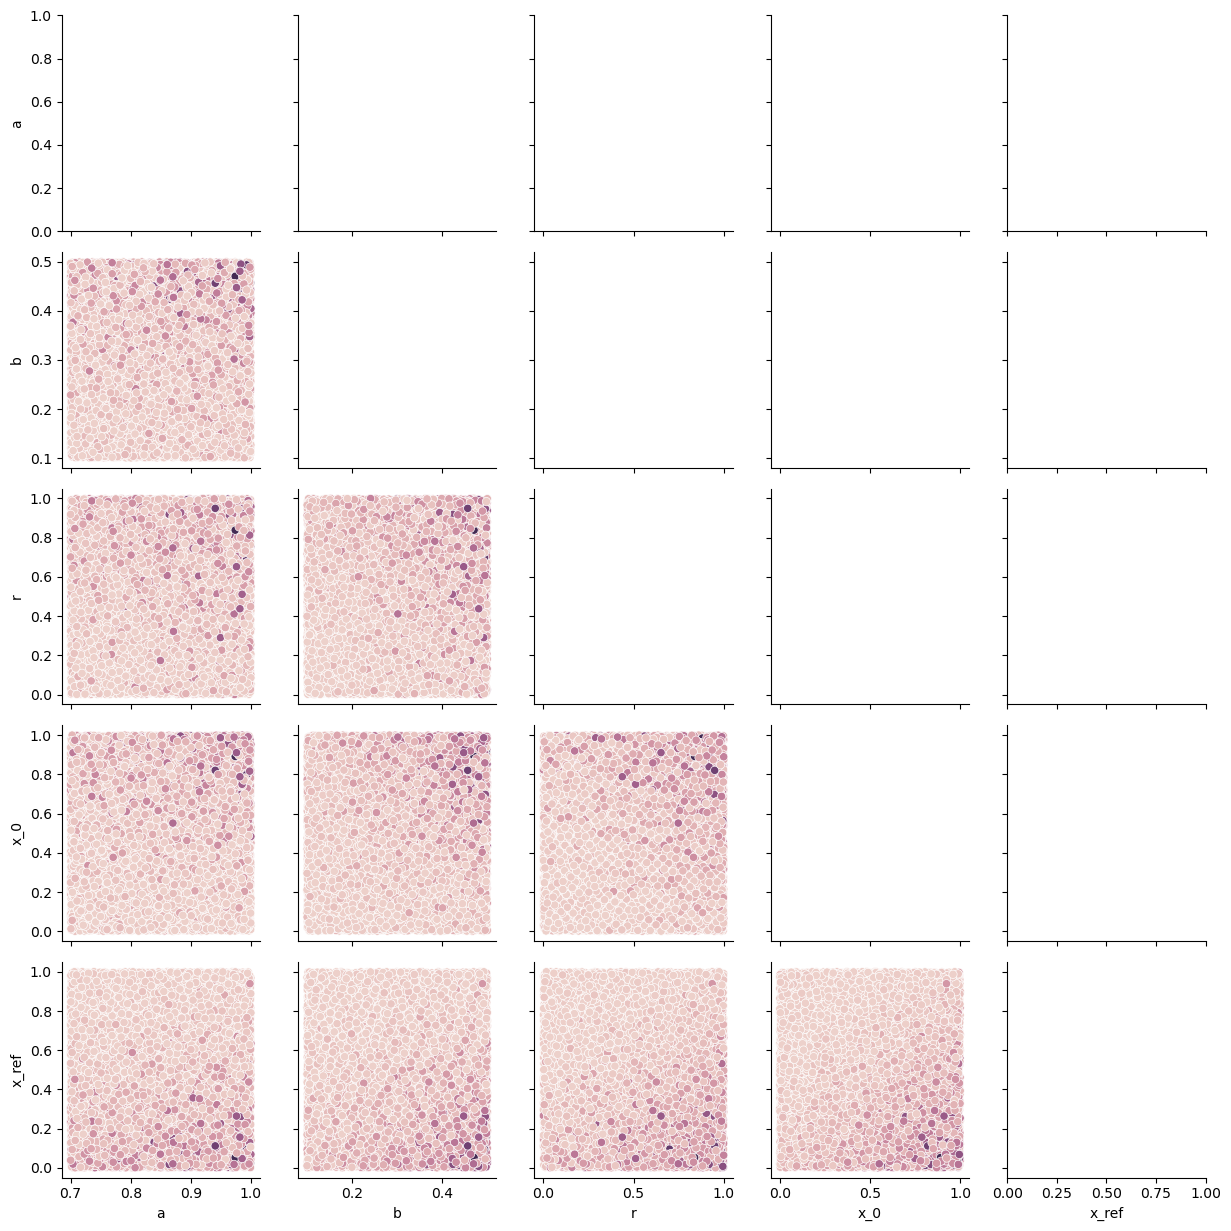

In [35]:
g = sns.PairGrid(df.drop(["feas", "compl"], 1), hue="stat")
g.map_lower(sns.scatterplot)

In [36]:
model.solnet.forward(a,b,r,x_0,x_ref)

tensor([[0.5544, 0.4882, 0.4667, 0.4645, 0.4329],
        [0.5342, 0.4514, 0.4864, 0.5130, 0.3981],
        [0.5481, 0.4865, 0.4896, 0.4985, 0.4332],
        ...,
        [0.5605, 0.5004, 0.4766, 0.4841, 0.4426],
        [0.5386, 0.4642, 0.4971, 0.4914, 0.4258],
        [0.5465, 0.4800, 0.4747, 0.4879, 0.4366]], device='mps:0',
       grad_fn=<SigmoidBackward0>)